In [1]:
import sys
sys.path.append(r'../')
import mat73
import numpy as np
from tqdm import tqdm
from scipy import signal
from matplotlib import cm
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import matplotlib.colors as mcolors
from matplotlib.lines import Line2D
import matplotlib.animation as animation

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.losses import Loss
from tensorflow.keras.models import Model
from tensorflow.keras import layers, losses
#from keras.utils.np_utils import to_categorical

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from sklearn.neighbors import NearestNeighbors
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

%reload_ext autoreload
%autoreload 2
from functions import *

2023-07-19 13:37:39.199861: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-19 13:37:41.924638: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-07-19 13:37:41.924660: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-07-19 13:37:42.349177: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-07-19 13:37:48.205591: W tensorflow/stream_executor/platform/de

### Loading the macrovariable

In [2]:
algorithm = 'autoregressor'
Y0_tr = np.loadtxt('Saved_Y/Y0_tr__'+ algorithm +'.csv')
Y1_tr = np.loadtxt('Saved_Y/Y1_tr__'+ algorithm +'.csv')
Y0_tst = np.loadtxt('Saved_Y/Y0_tst__'+ algorithm +'.csv')
Y1_tst = np.loadtxt('Saved_Y/Y1_tst__'+ algorithm +'.csv')
B_train_1 = np.loadtxt('Saved_Y/B_train_1__'+ algorithm +'.csv')
B_test_1 = np.loadtxt('Saved_Y/B_test_1__'+ algorithm +'.csv')

Y0_tr = Y0_tr.reshape(Y0_tr.shape[0],-1)
Y1_tr = Y1_tr.reshape(Y1_tr.shape[0],-1)
Y0_tst = Y0_tst.reshape(Y0_tst.shape[0],-1)
Y1_tst = Y1_tst.reshape(Y1_tst.shape[0],-1)
Ydiff_tr = Y1_tr - Y0_tr
Ydiff_tst = Y1_tst - Y0_tst

#### Plotting latent space dynamics


(0.0, 2686.0, -0.5, 0.5)

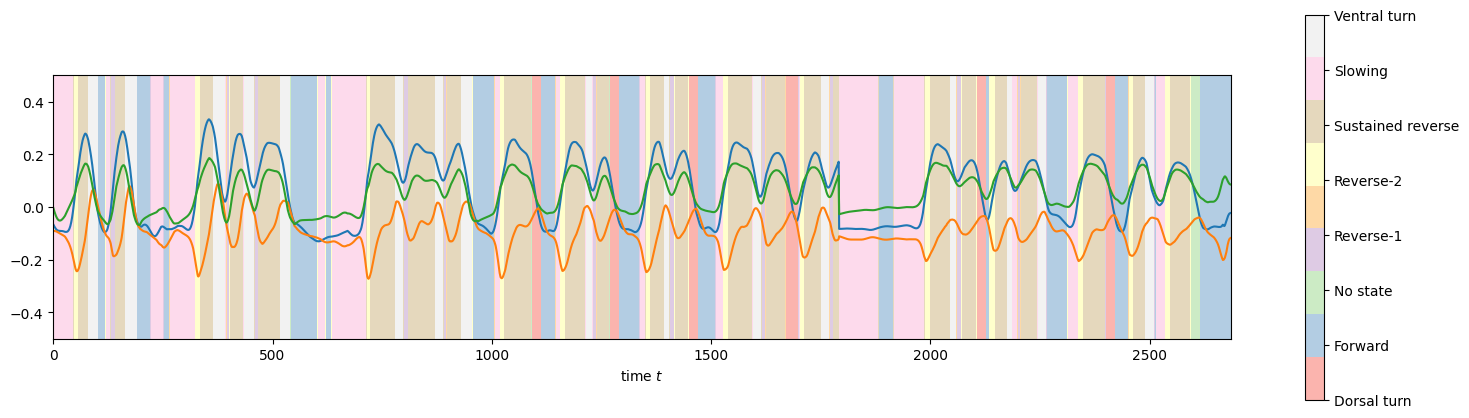

In [3]:
%matplotlib inline
plt.figure(figsize=(19,5))
plt.imshow([B_train_1],aspect=600,cmap="Pastel1")
cbar = plt.colorbar(ticks=np.arange(8))
cbar.ax.set_yticklabels(['Dorsal turn', 'Forward', 'No state', 'Reverse-1', 'Reverse-2', 'Sustained reverse', 'Slowing', 'Ventral turn']) 
plt.plot(Y0_tr/Y0_tr.max()/3)
plt.xlabel("time $t$")
plt.axis([0,Y0_tr.shape[0],-0.5,0.5])

### Behaviour predictor
#### With neural net

100%|████████████████████████████████████████| 50/50 [01:30<00:00,  1.82s/it]


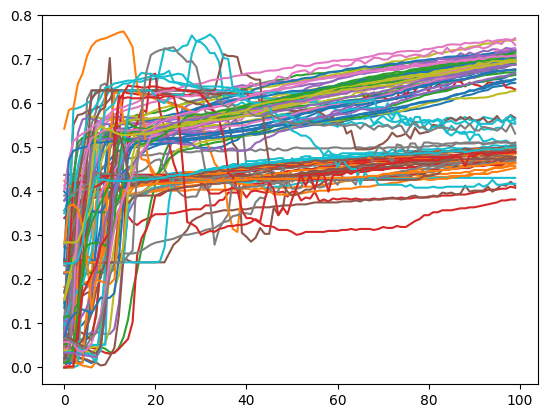

In [4]:
%matplotlib inline
acc_list = []
for i in tqdm(np.arange(50)):
    b_predictor = tf.keras.Sequential([
        #layers.Dense(80, activation='relu'),
        #layers.Dense(20, activation='relu'),
        #layers.Dense(8, activation='relu'),
        #layers.Normalization(axis=-1),
        layers.Dense(8, activation='linear')
    ]) 
    opt = tf.keras.optimizers.legacy.Adam(learning_rate=0.01)

    b_predictor.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])

    history = b_predictor.fit(Y1_tr,
                          B_train_1,
                          epochs=100,
                          batch_size=100,
                          validation_data=(Y1_tst, B_test_1),
                          verbose=0
                          )
    # Summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])

    B1_tst_pred = b_predictor(Y1_tst).numpy().argmax(axis=1)

    acc_list.append(accuracy_score(B1_tst_pred, B_test_1))

0.48799107142857145
0.0410226078239618


(array([ 1.,  4.,  1., 15., 20.,  4.,  1.,  3.,  0.,  1.]),
 array([0.38169643, 0.40669643, 0.43169643, 0.45669643, 0.48169643,
        0.50669643, 0.53169643, 0.55669643, 0.58169643, 0.60669643,
        0.63169643]),
 <BarContainer object of 10 artists>)

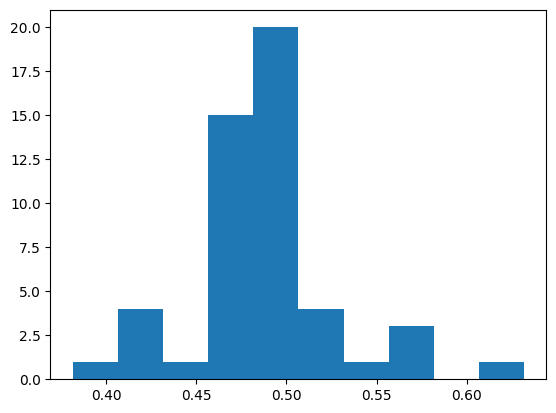

In [5]:
acc_list = np.array(acc_list)
np.savetxt('Saved evaluation metrics/acc_list_'+algorithm,acc_list)
print(np.mean(acc_list, axis=0))
print(np.std(acc_list, axis=0))
plt.hist(acc_list)

#### Behaviour predictor: with linear regression 
(deterministic as opposed to probabilistic neural net's solution)

In [6]:
B_train_1_onehot = tf.keras.utils.to_categorical(B_train_1, num_classes=8)
linear_reg = LinearRegression()
linear_reg.fit(Y1_tr, B_train_1_onehot)

B1_tr_pred = linear_reg.predict(Y1_tr).argmax(axis=1)
B1_tst_pred = linear_reg.predict(Y1_tst).argmax(axis=1)

accuracy_score(B1_tst_pred, B_test_1)

0.49330357142857145

### Chance accuracy

In [7]:
chance_acc = np.zeros(500)
for i, _ in enumerate(chance_acc):
    B_perm = np.random.choice(B_test_1, size=B_test_1.shape)
    chance_acc[i] = accuracy_score(B_perm, B_test_1)
print('Chance prediction accuracy: ', chance_acc.mean().round(3), ' pm ', chance_acc.std().round(3))

Chance prediction accuracy:  0.261  pm  0.02


### Autoregressor: Predicting $Y_{t+1}$ from $Y_t$
#### With neural net


100%|████████████████████████████████████████| 50/50 [00:48<00:00,  1.03it/s]


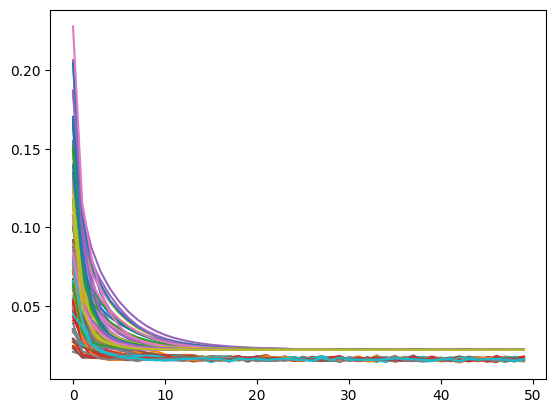

In [8]:
%matplotlib inline
mse_list = []
for i in tqdm(np.arange(50)):
    # Setting outliers to zero
    #Y_diff_tr[np.abs(Y_diff_tr) > Y_diff_tr.mean() + 3*Y_diff_tr.std()] = 0
    #Y_diff_tst[np.abs(Y_diff_tst) > Y_diff_tst.mean() + 3*Y_diff_tst.std()] = 0

    ### Scaling input and output data
    Yinmax = (np.abs(Y0_tr)).max() # Parameters for scaling
    Y0_tr, Y0_tst = Y0_tr/Yinmax, Y0_tst/Yinmax
    Ydmax = (np.abs(Ydiff_tr)).max() # Parameters for scaling
    Ydiff_tr, Ydiff_tst = Ydiff_tr/Ydmax, Ydiff_tst/Ydmax

    # Defining the model
    model_ydiff_f_yt = tf.keras.Sequential([
        #tf.keras.layers.Dense(3, activation='relu'),
        #tf.keras.layers.Dense(5, activation='relu'),
        #tf.keras.layers.Dense(7, activation='relu'),
        #tf.keras.layers.Dense(10, activation='relu'),
        #tf.keras.layers.Dense(7, activation='relu'),
        #tf.keras.layers.Dense(5, activation='relu'),
        tf.keras.layers.Dense(3, activation='linear')
    ])
    opt = tf.keras.optimizers.legacy.Adam(learning_rate=0.01)

    model_ydiff_f_yt.compile(optimizer=opt,
                  loss='mse',
                  metrics=['mse'])


    history = model_ydiff_f_yt.fit(Y0_tr,
                          Ydiff_tr,
                          epochs=50,
                          batch_size=100,
                          validation_data=(Y0_tst, Ydiff_tst),
                          verbose=0
                          )
    # Summarize history for accuracy
    plt.plot(history.history['mse'])
    plt.plot(history.history['val_mse'])

    # Preidctions
    Ydiff_tr_pred = model_ydiff_f_yt(Y0_tr).numpy()
    Ydiff_tst_pred = model_ydiff_f_yt(Y0_tst).numpy()

    # Inverse scaling the data
    Ydiff_tr_pred, Ydiff_tr, Y0_tr = Ydiff_tr_pred*Ydmax, Ydiff_tr*Ydmax, Y0_tr*Yinmax
    Ydiff_tst_pred, Ydiff_tst, Y0_tst = Ydiff_tst_pred*Ydmax, Ydiff_tst*Ydmax, Y0_tst*Yinmax

    Y1_tr_pred = Y0_tr + Ydiff_tr_pred
    Y1_tst_pred = Y0_tst + Ydiff_tst_pred

    # Evaluation
    baseline_tr  = mean_squared_error(flat_partial(Y1_tr), flat_partial(Y0_tr))
    modelmse_tr = mean_squared_error(flat_partial(Y1_tr), flat_partial(Y1_tr_pred))
    baseline_tst  = mean_squared_error(flat_partial(Y1_tst), flat_partial(Y0_tst))
    modelmse_tst = mean_squared_error(flat_partial(Y1_tst), flat_partial(Y1_tst_pred))
    
    #print('On training set \n')
    #print('Baseline mse', baseline_tr.round(5), 'Model mse:', modelmse_tr.round(5))
    #print('\nOn test set \n')
    #print('Baseline mse', baseline_tst.round(5), 'Model mse:', modelmse_tst.round(5))
    
    mse_list.append([baseline_tr, modelmse_tr, baseline_tst, modelmse_tst])

In [9]:
model_ydiff_f_yt(Y0_tr).shape


TensorShape([2686, 3])

[0.00221344 0.00076157 0.00092195 0.00055431]
[3.03576608e-18 1.82439894e-06 2.16840434e-19 2.58781662e-05]


(array([ 3.,  1.,  2.,  7.,  8.,  4., 10.,  5.,  9.,  1.]),
 array([0.33163986, 0.34371844, 0.35579701, 0.36787559, 0.37995416,
        0.39203274, 0.40411131, 0.41618989, 0.42826846, 0.44034704,
        0.45242561]),
 <BarContainer object of 10 artists>)

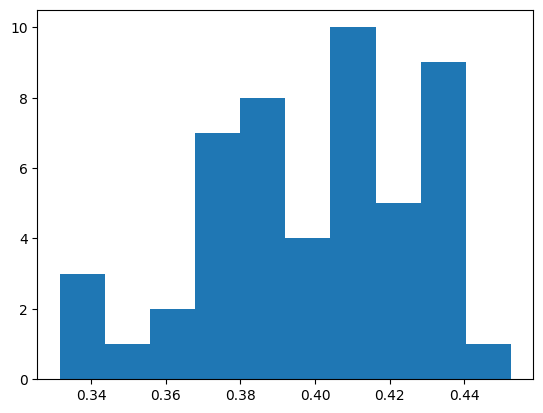

In [10]:
mse_list = np.array(mse_list)
np.savetxt('Saved evaluation metrics/mse_list_'+algorithm,mse_list)
print(np.mean(mse_list, axis=0))
print(np.std(mse_list, axis=0))
goodness_of_fit = 1 -  mse_list[:,3]/mse_list[:,2]
plt.hist(goodness_of_fit)

#### Autoregression: with linear regression 
(deterministic as opposed to probabilistic neural net's solution)

In [11]:
linear_reg = LinearRegression()
linear_reg.fit(Y0_tr, Ydiff_tr)

Ydiff_tr_pred = linear_reg.predict(Y0_tr)
Ydiff_tst_pred = linear_reg.predict(Y0_tst)

Y1_tr_pred = Y0_tr + Ydiff_tr_pred
Y1_tst_pred = Y0_tst + Ydiff_tst_pred

# Evaluation
baseline_tr  = mean_squared_error(flat_partial(Y1_tr), flat_partial(Y0_tr))
modelmse_tr = mean_squared_error(flat_partial(Y1_tr), flat_partial(Y1_tr_pred))
baseline_tst  = mean_squared_error(flat_partial(Y1_tst), flat_partial(Y0_tst))
modelmse_tst = mean_squared_error(flat_partial(Y1_tst), flat_partial(Y1_tst_pred))

print('On training set \n')
print('Baseline mse', baseline_tr.round(5), 'Model mse:', modelmse_tr.round(5))
print('\nOn test set \n')
print('Baseline mse', baseline_tst.round(5), 'Model mse:', modelmse_tst.round(5))

1 - modelmse_tst/baseline_tst

On training set 

Baseline mse 0.00221 Model mse: 0.00076

On test set 

Baseline mse 0.00092 Model mse: 0.00055


0.40614295176419357

### Hits at rank metric

In [12]:
hits_at_rank(5,Y1_tr, Y1_tr_pred)

0.8313477289650038

--------------

--------------